In [198]:
import pandas as pd 
import numpy as np 
from scipy.stats import norm, expon
import datetime
import holidays 
import matplotlib.pyplot as plt
import os
from pathlib import Path
import random

# Faza 1 - przygotowanie

## Wczytanie csv

In [143]:
def file_path(file_name: str):
    dir_path = [ i for i in Path.cwd().parents if i.name == 'geeks-and-dragons-db'][0]
    path = os.path.join(dir_path, 'config', 'prompts', file_name)
    if os.path.exists(path):
        return path
    else:
        raise FileNotFoundError('No such file')

In [323]:
prompt_games = pd.read_csv(file_path('gry.csv'))
prompt_first_names_males = pd.read_csv(file_path('imiona_m.csv'))
prompt_last_names_males = pd.read_csv(file_path('nazwiska_m.csv'))
prompt_first_names_females = pd.read_csv(file_path('imiona_k.csv'))
prompt_last_names_females = pd.read_csv(file_path('nazwiska_k.csv'))
prompt_cities = pd.read_csv(file_path('miasta.csv'))

## Tabela prompt_dates

In [172]:
shop_open_date = datetime.datetime(2021,6,1) #Dzień Dziecka bo tak 
today = datetime.datetime(2023,6,25)

In [174]:
weekday_dict = {'0':'Poniedziałek', '1':'Wtorek', '2':'Środa', '3':'Czwartek', '4':'Piątek', '5':'Sobota'}

def gen_dates(start_date, end_date):
    dates = []
    holidays_pl = holidays.Poland()
    current_date = start_date
    while current_date <= end_date:
        if current_date.weekday() != 6 and current_date not in holidays_pl:
            dates.append((current_date.date().strftime("%d-%m-%Y"), weekday_dict[str(current_date.weekday())]))
        current_date += datetime.timedelta(days=1)
    return dates

In [175]:
generated_dates = gen_dates(shop_open_date, today)

In [176]:
prompt_dates = pd.DataFrame(generated_dates, columns=['Data', 'Dzień tygodnia'])

## Ruch - dni

In [178]:
A = 6
B = 0.01 
dodatek_dzienny = {'Poniedziałek':'2', 'Wtorek':'1', 'Środa':'0', 'Czwartek':'4', 'Piątek':'5', 'Sobota':'5'}

volume_base = []
for i in range(len(prompt_dates['Dzień tygodnia'])):
    dd = int(dodatek_dzienny[prompt_dates['Dzień tygodnia'][i]])
    volume_base.append(A+B*i+dd)

In [179]:
prompt_dates['volume_base'] = volume_base

In [180]:
volume_sales = []
for v_base in prompt_dates['volume_base']:
    szum = round(norm.rvs(0,1.5))
    volume_sales.append(max(0,v_base+szum))

prompt_dates['volume_sales'] = volume_sales

In [181]:
volume_rental = []
for v_base in prompt_dates['volume_base']:
    szum = round(norm.rvs(0,1.5))
    volume_rental.append(max(0,0.4*v_base+szum))

prompt_dates['volume_rental'] = volume_rental

In [182]:
prompt_dates.head()

,Data,Dzień tygodnia,volume_base,volume_sales,volume_rental
0,01-06-2021,Wtorek,7.00,5.00,4.800
1,02-06-2021,Środa,6.01,6.01,4.404
2,04-06-2021,Piątek,11.02,13.02,4.408
3,05-06-2021,Sobota,11.03,12.03,5.412
4,07-06-2021,Poniedziałek,8.04,6.04,5.216


## Tabela procentowa z godzinami

In [183]:
hours = []
for i in range(8,20):
    if i < 18:
        hours.append((i, round(expon.rvs(i/2))))
    else:
        hours.append((i, round(expon.cdf(i/3))))          

In [184]:
hours_prompt = pd.DataFrame(hours, columns=['Godzina', 'Ilość klientów'])

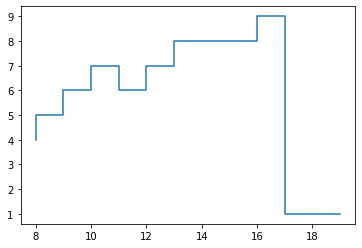

In [185]:
plt.step(range(8,20),hours_prompt['Ilość klientów'])

In [186]:
hours_prompt['Natężenie'] = [hours_prompt['Ilość klientów'][i]/sum(hours_prompt['Ilość klientów']) for i in range(len(hours_prompt['Godzina']))]

In [187]:
sum(hours_prompt['Natężenie'])

1.0

## Gry

In [188]:
prompt_games[1:] = prompt_games[1:].sample(frac = 1)

In [190]:
prompt_games.head()

,Nazwa,rodzaj,kategoria,opis,Turniej,Kupno,Wypożyczenie,Liczba uczestników,wagi
0,Jamniki,planszowa,familijna,"Podczas gry Twój jamnik będzie rósł, musisz wi...",NIE,59.99,NaN,NaN,0.045967
1,Władca Pierścieni Podróże Przez Śródziemie,planszowa,strategiczna,Wyrusz w Podróże przez Śródziemie z grą Władca...,NIE,315.95,NaN,NaN,0.024920
2,Ślimaki to mięczaki,planszowa,familijna,Najlepsza Dziecięca Gra Roku 2019! Takiego wyś...,NIE,45.49,NaN,NaN,0.014659
3,Dobry rok,planszowa,strategiczna,"Gra ""Dobry Rok"" sprawdzi się u dzieci w wieku ...",NIE,160.97,NaN,NaN,0.020320
4,Mastermind,planszowa,logiczna,Mastermind to gra znana chyba każdemu fanowi g...,TAK,26.19,NaN,2,0.011016


In [191]:
wagi = expon.pdf(x=np.linspace(0,2,len(prompt_games['Nazwa'])),loc=-1/9)
prompt_games['wagi'] = [wagi[i]/np.sum(wagi) for i in range(len(wagi))]

In [192]:
sum(prompt_games['wagi'])

1.0000000000000002

_______________

# Faza 2 - tabele pomocnicze

## Pracownicy

In [420]:
city_generator = lambda n: random.choices(prompt_cities['miasto'], weights=prompt_cities['prob'], k=n)


gender_generator = lambda n=6: random.choices(['M', 'F'], weights=[0.5, 0.5], k=n) 


salary_generator = lambda n=6: [round(3490 + expon.rvs(scale=100, loc=80), 2) for i in range(n)] #trzeba pomyśleć, bo jak jest zwolniony to nie może mieć wynagrodzenia (ma sens?)


def phone_generator(n=6):
    WST = [45, 50, 51, 53, 57, 60, 66, 69, 72, 73, 78, 79, 88]
    digit = [i for i in range(10)]
    phone_numbers = []
    while n > 0:
        phone = ''.join(map(str, [random.choice(WST), *random.choices(digit, k=7)]))
        if phone not in phone_numbers:
            phone_numbers.append(phone)
            n -= 1
        else:
            pass
    return phone_numbers


def first_name_generator(gender_list):
    names = []
    for gender in gender_list:
        if gender == 'M':
            names.append(*random.choices(prompt_first_names_males['imię'], weights=prompt_first_names_males['prob']))
        elif gender == 'F':
            names.append(*random.choices(prompt_first_names_females['imię'], weights=prompt_first_names_females['prob']))
    return names


def last_name_generator(gender_list):
    last_names = []
    for gender in gender_list:
        if gender == 'M':
            last_names.append(*random.choices(prompt_last_names_males['nazwisko'], weights=prompt_last_names_males['prob']))
        elif gender == 'F':
            last_names.append(*random.choices(prompt_last_names_females['nazwisko'], weights=prompt_last_names_females['prob']))
    return last_names


#wstępna wersja, bo jeszcze nie ma csv + trzeba zabezpieczyć przed powtórkami!
def email_generator(df):
    emails = df['first_name'].str.cat(df['last_name'], sep='.')
    emails = emails.apply(lambda x: '@'.join([x, 'poczta.pl']))
    return emails


def is_manager(df):
    index = df.loc[df['current_salary'] == df['current_salary'].max()].index[0]
    df.at[index, 'is_manager'] = True


In [421]:
staff = pd.DataFrame({
    'city': [*city_generator(6)],
    'gender': [*gender_generator()],
    'phone': [*phone_generator()],
    'current_salary': [*salary_generator()],
    'is_manager': [False for i in range(6)]
})

In [422]:
staff['first_name'] = first_name_generator(staff['gender'])
staff['last_name'] = last_name_generator(staff['gender'])
staff['email'] = email_generator(staff)
is_manager(staff)
staff

,city,gender,phone,current_salary,is_manager,first_name,last_name,email
0,Zgorzelec,F,571739244,3710.61,False,MARTYNA,GAWRON,MARTYNA.GAWRON@poczta.pl
1,Wrocław,M,601047334,3868.97,True,DANIEL,MATYSIAK,DANIEL.MATYSIAK@poczta.pl
2,Oława,M,667036434,3613.25,False,OLAF,KACZMARCZYK,OLAF.KACZMARCZYK@poczta.pl
3,Strzegom,M,515035062,3604.23,False,MARIAN,DZIURA,MARIAN.DZIURA@poczta.pl
4,Dzierżoniów,M,738224940,3577.46,False,FABIAN,KOLASIŃSKI,FABIAN.KOLASIŃSKI@poczta.pl
5,Pieszyce,F,570346274,3583.42,False,MARTYNA,KRAWIEC,MARTYNA.KRAWIEC@poczta.pl


## Godziny pracy

## Związki

## Partnerzy

## Klienci - część A

## Koszty utrzymania

## Tytuły wydatków

## Typy wydatków

## Wydatki i tytuły jeszcze raz

## Turnieje

## Udziały

## Magazyn

## Ceny gier

## Sprzedaże

## Rentale

## Gry

## Katrgorie gier i typy gier

## Klienci - część B

## Miasta

## Payments i invoices

------

# Faza 3 - ostateczne tabele